#   Global Earthquake–Tsunami Risk Assessment
# Phase 3


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving earthquake_data_tsunami (1).csv to earthquake_data_tsunami (1).csv


In [ ]:
import pandas as pd
df = pd.read_csv('earthquake_data_tsunami (1).csv')

In [ ]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (782, 13)


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [7]:
# ============================================================
# 1. Import Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from itertools import product


In [9]:

# ============================================================
# 2. Load Dataset
# ============================================================
df = pd.read_csv('/content/earthquake_data_tsunami (1).csv')
df = df.dropna()


In [10]:

# ============================================================
# 3. Remove Label (Unsupervised Learning)
# ============================================================
X = df.drop(columns=['tsunami'])   # ← Remove class label

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:

# ============================================================
# 4. K-Means Clustering
# ============================================================
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
wcss = kmeans.inertia_

print("=== K-MEANS RESULTS ===")
print("Silhouette Score:", sil_kmeans)
print("WCSS (Within-Cluster Sum of Squares):", wcss)


=== K-MEANS RESULTS ===
Silhouette Score: 0.18211987254875867
WCSS (Within-Cluster Sum of Squares): 7758.686659018821


In [12]:

# ============================================================
# 5. Hierarchical (Agglomerative) Clustering
# ============================================================
agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, agg_labels)

print("\n=== AGGLOMERATIVE RESULTS ===")
print("Silhouette Score:", sil_agg)



=== AGGLOMERATIVE RESULTS ===
Silhouette Score: 0.15950932422754477


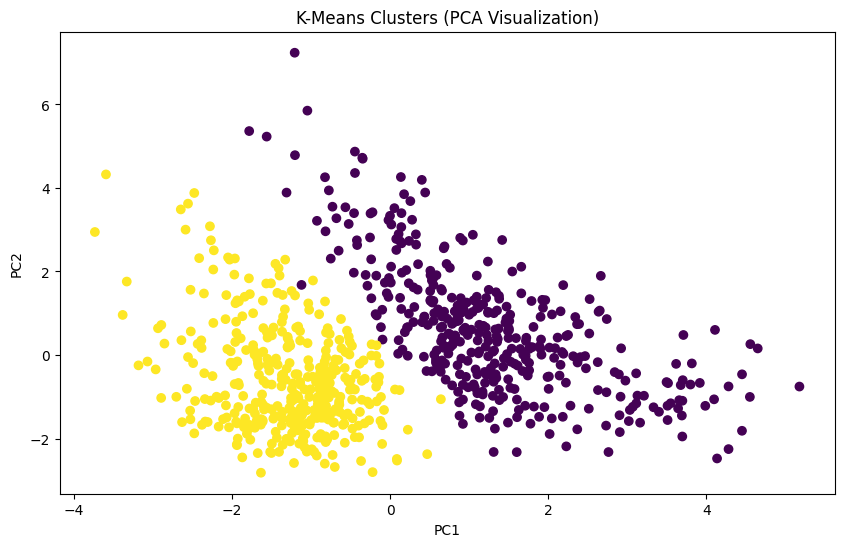

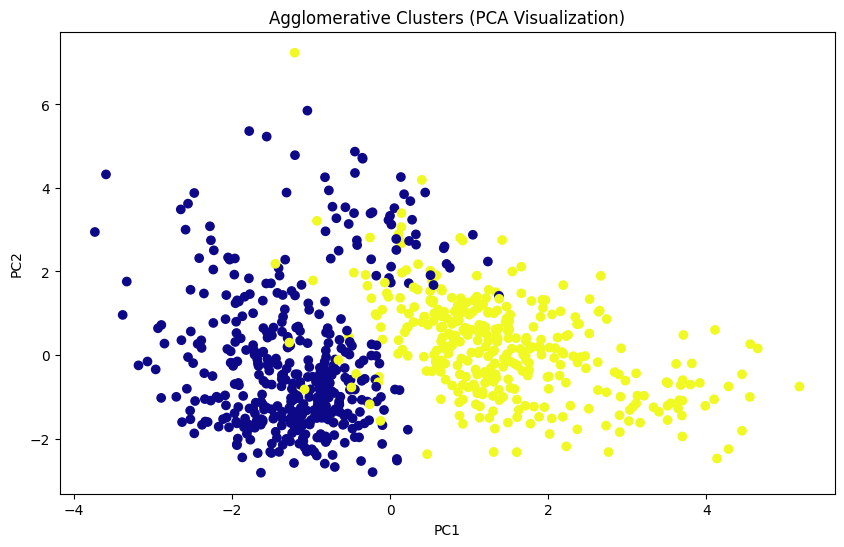

In [13]:

# ============================================================
# 6. PCA Visualizations
# ============================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clusters (PCA Visualization)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Agglomerative Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='plasma')
plt.title("Agglomerative Clusters (PCA Visualization)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [16]:

# ============================================================
# 7. BCubed Precision & Recall
# ============================================================

def bcubed_precision(labels_true, labels_pred):
    precision_vals = []
    for i, j in product(range(len(labels_true)), repeat=2):
        if labels_pred[i] == labels_pred[j]:
            precision_vals.append(1 if labels_true[i] == labels_true[j] else 0)
    return np.mean(precision_vals)

def bcubed_recall(labels_true, labels_pred):
    recall_vals = []
    for i, j in product(range(len(labels_true)), repeat=2):
        if labels_true[i] == labels_true[j]:
            recall_vals.append(1 if labels_pred[i] == labels_pred[j] else 0)
    return np.mean(recall_vals)

y_true = df['tsunami'].values  # Only for evaluation

bc_prec_kmeans = bcubed_precision(y_true, kmeans_labels)
bc_rec_kmeans = bcubed_recall(y_true, kmeans_labels)

bc_prec_agg = bcubed_precision(y_true, agg_labels)
bc_rec_agg = bcubed_recall(y_true, agg_labels)

print("\n=== BCUBED PRECISION & RECALL ===")
print(f"K-Means Precision: {bc_prec_kmeans:.3f}")
print(f"K-Means Recall: {bc_rec_kmeans:.3f}")
print(f"Agglomerative Precision: {bc_prec_agg:.3f}")
print(f"Agglomerative Recall: {bc_rec_agg:.3f}")



=== BCUBED PRECISION & RECALL ===
K-Means Precision: 0.751
K-Means Recall: 0.716
Agglomerative Precision: 0.696
Agglomerative Recall: 0.669


# **Insight and Algorithm Justification**

We applied K-Means clustering as our unsupervised learning algorithm because it works well with numerical data like magnitude, depth, and distance, and it efficiently groups similar earthquakes based on their characteristics. K-Means is also easy to interpret and provides useful evaluation metrics such as the Silhouette Score and WCSS, which help measure how well the data naturally forms clusters.

The clusters we discovered reveal natural patterns in the earthquake data, such as differences in magnitude, depth, or geographic location. These patterns can still be valuable even though the model was trained without the tsunami label.

How clustering can help the supervised model:

1️⃣ Feature Engineering
Adding the cluster ID as a new feature can give the supervised model extra information about natural groupings in the data.

2️⃣ Understanding the Data
Clusters help show whether earthquake characteristics naturally separate tsunami and non-tsunami events. If separation exists, the supervised model can benefit.

3️⃣ Identifying Weaknesses
If scores like Silhouette or BCubed are low, it means the data does not form clear clusters. In this case, integrating cluster labels would not help and may reduce accuracy.

Conclusion:
Clustering provides insight into how earthquakes group together. If the clusters are meaningful, they can be used to strengthen the supervised model. If not, they should be excluded.